# ✈️ Analisis dan Prediksi Kepuasan Penumpang Maskapai menggunakan Random Forest Classifier ✈️

Kelompok 11

- Fadhil Rausyanfikr | 23525046

- Muhammad Mukhlis | 23525045

- Yovanka Sandrina Maharaja | 18222094

## 📦 1. Import Libraries & Modules

Mengimpor pustaka penting untuk manipulasi data (Pandas, Numpy), visualisasi (Seaborn, Matplotlib), dan pemodelan (Scikit-Learn).

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Visualisation Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 120

## 📂 2. Load Dataset

Memuat dataset Airline Passenger Satisfaction ke dalam DataFrame.

In [85]:
# Read train and test files
df_train = pd.read_csv("https://drive.google.com/uc?id=1npGWo1guLxFKbdzFz6GNhlLoDIf4m-3v")
df_test = pd.read_csv("https://drive.google.com/uc?id=1pCMuq8AXt14Vb3Pcv3oS0FcPuB8lip7P")

# Combine both datasets
df = pd.concat([df_train, df_test], ignore_index=True)

## 🧐 3. Data Overview & Structure

Pemeriksaan awal dimensi data, tipe data, dan sampel baris.

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         129880 non-null  int64  
 1   id                                 129880 non-null  int64  
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Inflight wifi service              129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Ease of Online booking             129880 non-null  int64  
 11  Gate location                      1298

In [91]:
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [94]:
df.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

## 🧹 4. Data Cleaning

Mengecek dan menangani Missing Values (Imputasi) serta menghapus duplikasi atau kolom yang tidak relevan (seperti ID).

In [97]:
# a. Cleaning: Drop unnecessary columns
# 'Unnamed: 0', 'id' are identifiers/artifacts not useful for prediction
cols_to_drop = ['Unnamed: 0', 'id']
df_clean = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# b. Validation & Cleaning: Handle Missing Values
# Based on the df.info, 'Arrival Delay in Minutes' has missing values.
# We fill with median (robust to outliers).
df_clean['Arrival Delay in Minutes'] = df_clean['Arrival Delay in Minutes'].fillna(df_clean['Arrival Delay in Minutes'].median())

## ⚙️ 5. Data Preprocessing & Encoding

Mengubah variabel kategorikal (Gender, Type of Travel) menjadi numerik (Label/One-Hot Encoding) agar bisa diproses oleh model.

In [100]:
# a. Feature Engineering
# Create 'Total Delay'
df_clean['Total Delay'] = df_clean['Departure Delay in Minutes'] + df_clean['Arrival Delay in Minutes']

# Create 'Delay Category' (No Delay, Short Delay, Long Delay)
def categorize_delay(x):
    if x == 0: return 'No Delay'
    elif x <= 30: return 'Short Delay'
    else: return 'Long Delay'
df_clean['Delay Category'] = df_clean['Total Delay'].apply(categorize_delay)

# b. Encoding
# Label Encoding for Target ('satisfaction')
satisfaction_map = {'neutral or dissatisfied': 0, 'satisfied': 1}
df_clean['satisfaction_encoded'] = df_clean['satisfaction'].map(satisfaction_map)

# Ordinal Encoding for 'Class' (Order matters)
class_map = {'Eco': 1, 'Eco Plus': 2, 'Business': 3}
df_clean['Class_encoded'] = df_clean['Class'].map(class_map)

# One-Hot Encoding for nominal variables (Gender, Customer Type, Type of Travel)
# We use get_dummies just to show how it's done, but keep the original columns for EDA readability
df_encoded = pd.get_dummies(df_clean, columns=['Gender', 'Customer Type', 'Type of Travel', 'Delay Category'], drop_first=True)

# Drop original columns that are no longer needed since numeric versions exist
cols_to_drop = ['satisfaction', 'Class'] 
df_final = df_encoded.drop(columns=[c for c in cols_to_drop if c in df_encoded.columns])

## 📊 6. Exploratory Data Analysis (EDA)

Visualisasi mendalam untuk memahami distribusi data dan pola kepuasan penumpang.

In [103]:
print("--- SHAPE ---")
print(df_clean.shape)
print("\n--- INFO ---")
print(df_clean.info())
print("\n--- DESCRIBE (Numerical) ---")
print(df_clean.describe())

--- SHAPE ---
(129880, 27)

--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Inflight wifi service              129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Ease of Online booking             129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Food and drink                     129880 non-null  int64  
 11

### a. Visualisasi Distribusi Kepuasan berdasarkan Kelas dan Tipe Perjalanan

<Figure size 1200x720 with 0 Axes>

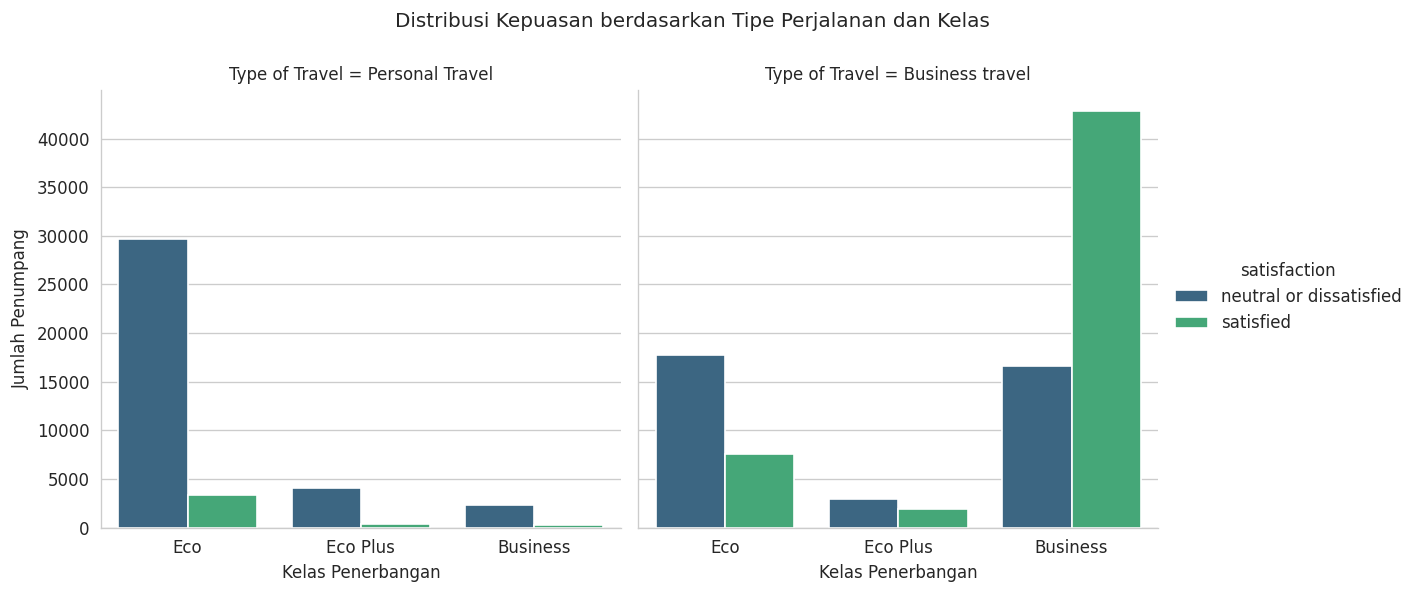

In [106]:
plt.figure(figsize=(10, 6))

g = sns.catplot(
    data=df_clean, 
    x='Class', 
    hue='satisfaction', 
    col='Type of Travel', 
    kind='count', 
    palette='viridis',
    height=5, 
    aspect=1,
    order=['Eco', 'Eco Plus', 'Business'] 
)

g.set_axis_labels("Kelas Penerbangan", "Jumlah Penumpang")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Distribusi Kepuasan berdasarkan Tipe Perjalanan dan Kelas')
plt.show()

### ⚖️b.  "The Service Gap": Boxplot Layanan Kunci vs. Kepuasan

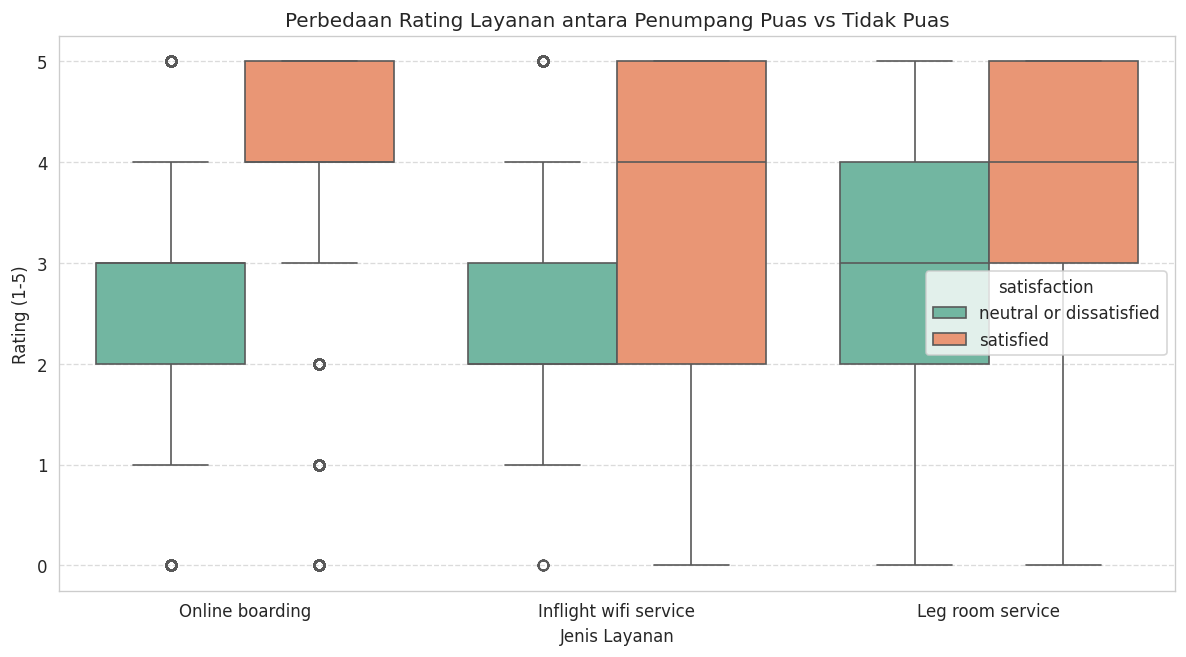

In [109]:
# Choose feature for analysis
service_cols = ['Online boarding', 'Inflight wifi service', 'Leg room service']

# Melt the dataframe to allow simultaneous plotting
df_melted = df_clean.melt(id_vars='satisfaction', value_vars=service_cols, 
                          var_name='Jenis Layanan', value_name='Rating (1-5)')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='Jenis Layanan', y='Rating (1-5)', hue='satisfaction', palette='Set2')

plt.title('Perbedaan Rating Layanan antara Penumpang Puas vs Tidak Puas')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 🌡️ c. Correlation Heatmap

Melihat hubungan korelasi antar variabel numerik.

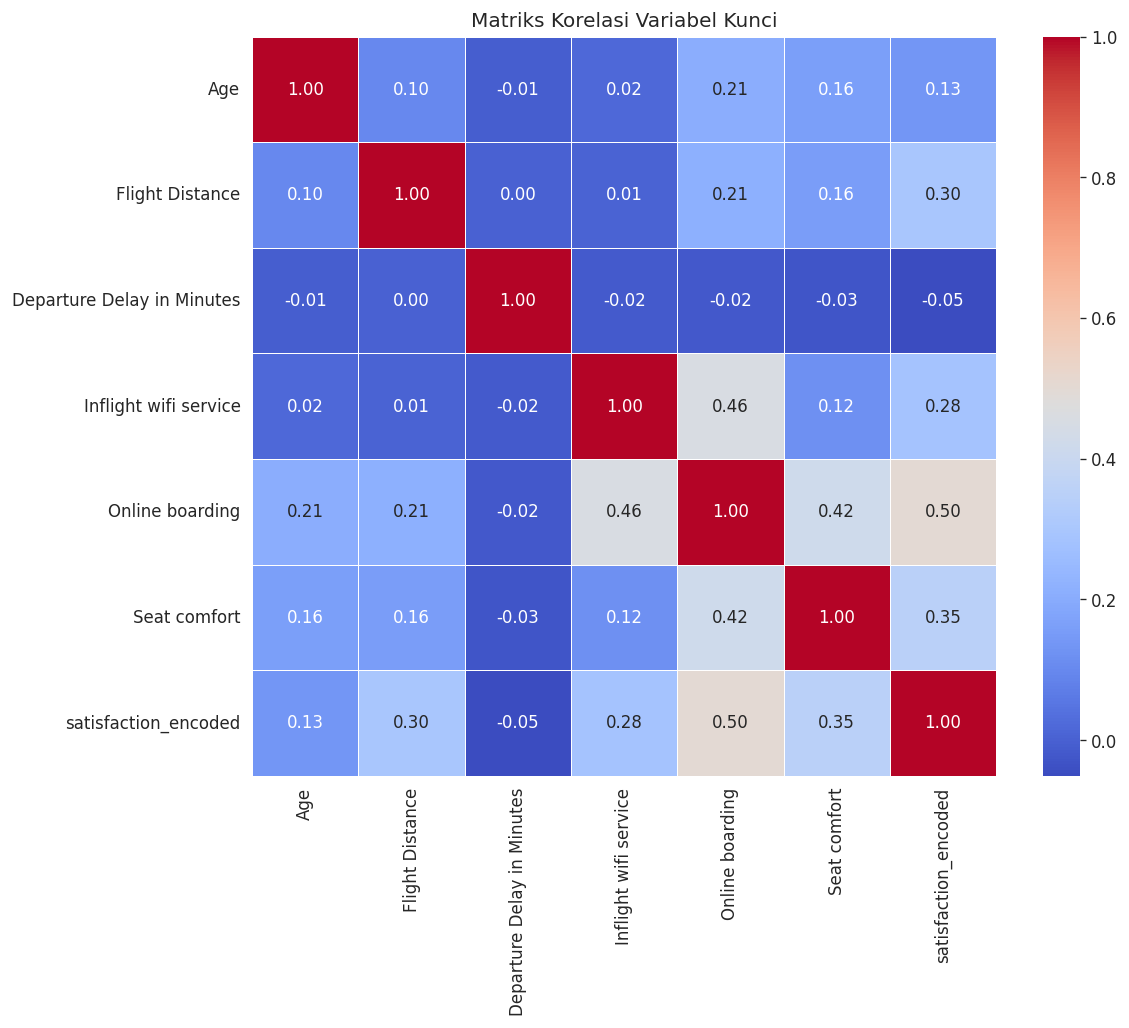

In [112]:
#Select numeric columns, key service ratings, and target encoded features
cols_to_corr = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 
                'Inflight wifi service', 'Online boarding', 'Seat comfort', 
                'satisfaction_encoded']

plt.figure(figsize=(10, 8))
correlation = df_clean[cols_to_corr].corr()

# Plot heatmap
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Matriks Korelasi Variabel Kunci')
plt.show()

## ✂️ 7. Data Splitting

Membagi data menjadi Training Set (80%) untuk melatih model dan Testing Set (20%) untuk validasi.

In [115]:
# Define X (Features) and y (Target)
X = df_final.drop(columns=['satisfaction_encoded'])
y = df_final['satisfaction_encoded']

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape}")
print(f"Testing Data : {X_test.shape}")

Training Data: (103904, 25)
Testing Data : (25976, 25)


## 🤖 8. Model Training

Membangun dan melatih model pada data training.

In [118]:
# Initialize Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Training
print("Training model...")
rf_model.fit(X_train, y_train)
print("Model Training Complete!")

Training model...
Model Training Complete!


## 📉 9. Model Evaluation

Mengukur performa model menggunakan metrik Akurasi, Confusion Matrix, dan Classification Report.

Model Accuracy: 96.21%

--- Detailed Classification Report ---
                      precision    recall  f1-score   support

Neutral/Dissatisfied       0.95      0.98      0.97     14622
           Satisfied       0.97      0.94      0.96     11354

            accuracy                           0.96     25976
           macro avg       0.96      0.96      0.96     25976
        weighted avg       0.96      0.96      0.96     25976



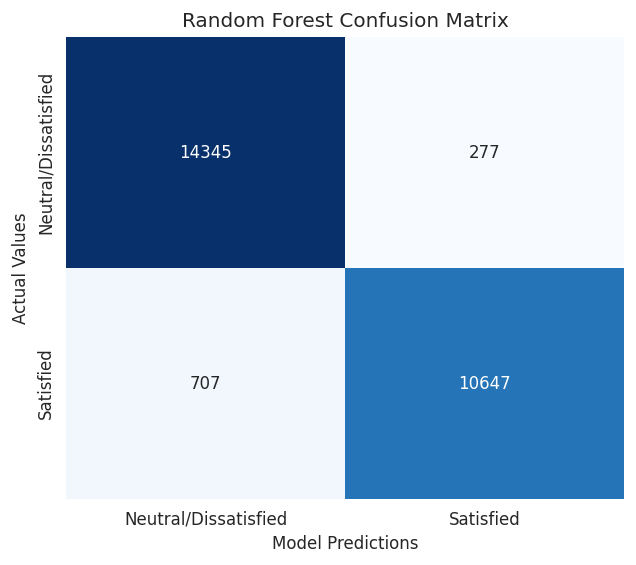

In [121]:
# Predictions
y_pred = rf_model.predict(X_test)

# a. Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc * 100:.2f}%\n")

# b. Classification Report
print("--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Neutral/Dissatisfied', 'Satisfied']))

# c. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Neutral/Dissatisfied', 'Satisfied'],
            yticklabels=['Neutral/Dissatisfied', 'Satisfied'])
plt.ylabel('Actual Values')
plt.xlabel('Model Predictions')
plt.title('Random Forest Confusion Matrix')
plt.show()

## 🌟 10. Feature Importance Analysis

Mengidentifikasi fitur/faktor layanan mana yang paling berpengaruh terhadap kepuasan penumpang.

/tmp/ipykernel_47/197531061.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='magma')


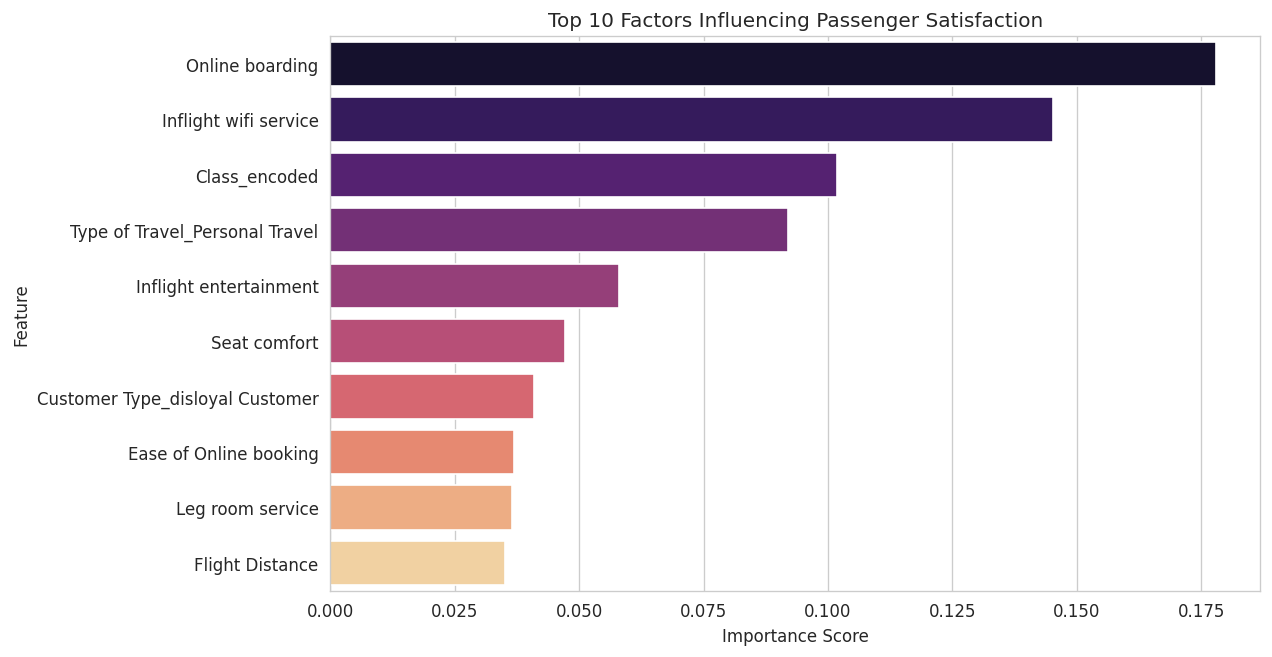

The #1 factor most influencing passenger satisfaction is Online boarding.


In [127]:
# Extract Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='magma')
plt.title('Top 10 Factors Influencing Passenger Satisfaction')
plt.xlabel('Importance Score')
plt.show()

top_feature = feature_df.iloc[0]['Feature']
print(f"The #1 factor most influencing passenger satisfaction is {top_feature}.")

## 💾 11. Conclusion & Saving Model

Menyimpan model yang sudah dilatih (pickle untuk penggunaan masa depan.

In [130]:
import pickle

# --- a. Brief Conclusion ---
print(f"Random Forest model successfully built with Accuracy: {acc * 100:.2f}%")
print("This model can now predict if a passenger will be SATISFIED or DISSATISFIED")
print("based on their flight data and service ratings.")

# --- b. Saving the Model ---
filename = 'airline_satisfaction_rf_model.pkl'

# Open file in 'wb' (write binary) mode
with open(filename, 'wb') as file:
    pickle.dump(rf_model, file)

print(f"\nModel successfully saved! Filename: '{filename}'")

Random Forest model successfully built with Accuracy: 96.21%
This model can now predict if a passenger will be SATISFIED or DISSATISFIED
based on their flight data and service ratings.

Model successfully saved! Filename: 'airline_satisfaction_rf_model.pkl'
